In [3]:
# %%capture
# !git clone https://github.com/Reclist/reclist/
# !cd reclist ; pip install -e .

# !git clone https://github.com/RecList/evalRS-KDD-2023
# !cd evalRS-KDD-2023 ; git checkout readme_kdd_2023

In [4]:
# !which python
# !pip install -r evalRS-KDD-2023/requirements.txt

In [5]:
import sys
sys.path.insert(0, 'evalRS-KDD-2023/evaluation')

In [22]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import random
from tqdm import tqdm
from sklearn.manifold import TSNE
from gensim.models import Word2Vec, KeyedVectors
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# sns.set_theme("notebook")
# Change notebook data format to be like 100.10 instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [1]:
import os
import sys
sys.path.append("evalRS-KDD-2023/evaluation")
from EvalRSRunner import ChallengeDataset
from EvalRSReclist import EvalRSReclist
from reclist.reclist import LOGGER, METADATA_STORE
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np

In [3]:
dataset = ChallengeDataset(force_download=False)

evalrs_dataset_KDD_2023.zip: 100%|██████████| 1.60G/1.60G [00:27<00:00, 62.5MB/s]


Loading dataset.
Generating Train/Test Split.
Generating dataset hashes.


In [4]:
# Create test train dataset
train, test = dataset.get_sample_train_test()
train.shape, test.shape

((6869679, 6), (29722, 3))

In [5]:
# Initial analysis
# No point combining cause time stamp information is null so irrelevant and all the test users are present in train set. So just use customerN from train df

# convert the timestamp in a more convenient format
train["timestamp"] = pd.to_datetime(train["timestamp"], unit="s")

# A session id per customer based on a 6 hr window, if their last session was more than 6 hrs ago, then it is a new session
train['session_id'] = train.groupby(['user_id', pd.Grouper(key='timestamp', freq='6H')]).ngroup()

In [7]:
## User impression median

In [6]:
# Get median impressions viewed - CustomerN
user_session_df = train.groupby(['user_id', 'session_id'])['track_id'].count().reset_index()
user_session_df.columns = ['user_id', 'session_id', 'tracks_listened']
user_summary = user_session_df.groupby('user_id').agg({'tracks_listened': np.median, 'session_id': 'nunique'})
user_summary = user_summary.reset_index()
user_summary.columns = ['user_id', 'customern_tracks', 'session_count']
user_summary['customern_tracks'] = user_summary['customern_tracks'].apply(int)

In [8]:
user_summary.head()

,user_id,customern_tracks,session_count
0,384,3,47
1,10879,6,29
2,12619,2,38
3,14308,3,39
4,15067,8,31


In [9]:
class EvalRSSimpleModel:
    """
    This is a dummy model that returns random predictions on the EvalRS dataset.
    """
    def __init__(self, items: pd.DataFrame, top_k: int=10, **kwargs):
        self.items = items
        self.top_k = top_k
        print("Received additional arguments: {}".format(kwargs))

    def predict(self, user_ids: pd.DataFrame) -> pd.DataFrame:
        k = self.top_k
        num_users = len(user_ids)
        pred = self.items.sample(n=k*num_users, replace=True).index.values
        pred = pred.reshape(num_users, k)
        pred = np.concatenate((user_ids[['user_id']].values, pred), axis=1)
        return pd.DataFrame(pred, columns=['user_id', *[str(i) for i in range(k)]]).set_index('user_id')

In [10]:
# dummy model
my_df_model = EvalRSSimpleModel(dataset.df_tracks, top_k=100)
# get some predictions
df_predictions = my_df_model.predict(dataset._test_set[['user_id']])

Received additional arguments: {}


In [11]:
df_predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
384,869666,4840334,494679,1494007,1732616,1128860,3614811,1881883,403110,1715242,...,49231,5516936,193767,1514637,8088850,1191462,2255420,187112,308426,541247
10879,53759,3239128,1439998,2336375,4238901,1042395,2578506,2286303,180161,506029,...,1711039,871116,1258198,1338825,272628,23491,930368,1388610,203452,841202
12619,325983,8221042,15639449,640284,3178290,396451,8995940,26974049,1622494,2626488,...,17492780,2598504,397503,87694,1373608,652606,400269,1265506,1350405,511083
14308,1352736,632498,7527458,4542322,784468,1147236,523135,1097779,815269,5134555,...,1039789,3967103,722486,1225831,1139667,1364817,892471,1013883,3808630,381187
15067,29772923,132388,100616,356979,332272,230821,53788,4302711,3925025,567497,...,584569,1340799,6112001,531189,33652,1686458,634311,1945006,135158,427535


In [80]:
def get_customern_predictions(df: pd.DataFrame, customern_df: pd.DataFrame) -> pd.DataFrame:
  df = df.reset_index()
  # Convert from wide to long format
  df = pd.melt(df, id_vars='user_id', value_vars=df_predictions.columns[1:])
  df.columns = ['user_id', 'impression_pos', 'impression_id']

  # merge with CustomerN median impressions df
  df = df.merge(user_summary, how='inner', on = ['user_id'])
  df_prediction_cn = df_predictions_long.merge(customern_df, how='inner', on = ['user_id'])
  df_prediction_cn['impression_pos'] = df_prediction_cn['impression_pos'].astype(int)

  # Remove impression values higher than CustomerN value
  df_prediction_cn = df_prediction_cn[df_prediction_cn['impression_pos'] <= df_prediction_cn['customern_tracks']-1]

  # Filter relevant columns
  df_prediction_cn = df_prediction_cn[['user_id', 'impression_pos', 'impression_id']]

  # As type
  df_prediction_cn['impression_pos'] = df_prediction_cn['impression_pos'].astype(str)
  df_prediction_cn['impression_id'] = df_prediction_cn['impression_id'].astype(str)

  # Pivot from long to wide
  df_prediction_cn = df_prediction_cn.pivot(index='user_id', columns='impression_pos', values='impression_id')

  # Correct multi-level index
  # flattened_columns = [''.join(col) for col in df_prediction_cn.columns]
  # df_prediction_cn.columns = flattened_columns

  # df_prediction_cn = df_prediction_cn.fillna('')

  df_prediction_cn = df_prediction_cn.reset_index()

  sorted_cols = sorted([col for col in df_prediction_cn.columns if col != 'user_id'], key=int)
  cols = ['user_id'] + sorted_cols
  df_prediction_cn = df_prediction_cn[cols]

  df_prediction_cn = df_prediction_cn.fillna(0)
  df_prediction_cn.index.name = None

  return df_prediction_cn

In [81]:
df_prediction_cn = get_customern_predictions(df_predictions, user_summary)

In [82]:
df_prediction_cn.head()

impression_pos,user_id,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,384,869666,4840334,494679,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10879,53759,3239128,1439998,2336375,4238901,1042395,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12619,325983,8221042,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14308,1352736,632498,7527458,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15067,29772923,132388,100616,356979,332272,230821,53788,4302711,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# initialize with everything - random model

# load a similarity model: here we used
similarity_model = KeyedVectors.load(os.path.join(dataset.path_to_dataset, 'song2vec.wv'))

# initialize with everything
cdf = EvalRSReclist(
    dataset=dataset,
    model_name="SimpleModel",
    predictions=df_prediction_cn,
    logger=LOGGER.LOCAL,
    metadata_store=METADATA_STORE.LOCAL,
    similarity_model=similarity_model,
)

# run reclist
cdf(verbose=True)

In [18]:
# CBOW model

In [25]:
class CBOWRecSys:

    def __init__(self, top_k: int=100):
        super(CBOWRecSys, self).__init__()
        """
        :param top_k: numbers of recommendation to return for each user. Defaults to 20.
        """
        self.top_k = top_k
        self.mappings = None

    def train(self, train_df: pd.DataFrame, **kwargs):
        print("Training model")

        # let's put tracks in order
        df = train_df[['user_id', 'track_id', 'timestamp']].sort_values('timestamp')

        # we group by user and create sequences of tracks
        p = df.groupby('user_id', sort=False)['track_id'].agg(list)

        # we now build "sentences" : sequences of tracks
        sentences = p.values.tolist()

        # train word2vec:
        # large window and small vector size...lots of epochs
        self.mymodel = Word2Vec(sentences, min_count=0, vector_size=20, window=40, epochs=5)

        user_tracks = pd.DataFrame(p)

        # we sample 10 songs for each user
        user_tracks["track_id_sampled"] = user_tracks["track_id"].apply(lambda x : random.choices(x, k=40))

        self.mappings = user_tracks.T.to_dict()

    def predict(self, user_ids: pd.DataFrame) -> pd.DataFrame:
        """

        This function takes as input all the users that we want to predict the top-k items for, and
        returns all the predicted songs.

        While in this example is just a random generator, the same logic in your implementation
        would allow for batch predictions of all the target data points.

        """
        user_ids = user_ids.copy()
        k = self.top_k


        pbar = tqdm(total=len(user_ids), position=0)

        predictions = []
        for user in user_ids["user_id"]:
            user_tracks = self.mappings[user]["track_id_sampled"]
            get_user_embedding = np.mean([self.mymodel.wv[t] for t in user_tracks], axis=0)

            # we need to filter out stuff from the user history. We don't want to suggest to the user something they
            # have already listened to
            max_number_of_returned_items = len(self.mappings[user]["track_id"]) + self.top_k

            user_predictions = [k[0] for k in self.mymodel.wv.most_similar(positive=[get_user_embedding], topn=max_number_of_returned_items)]
            user_predictions = list(filter(lambda x: x not in self.mappings[user]["track_id"], user_predictions))[0:self.top_k]

            predictions.append(user_predictions)

            pbar.update(1)
        pbar.close()

        # lil trick to reconstruct a dataframe that has user ids as index and the predictions as columns
        # This is a very important part! consistency in how you return the results is fundamental for the evaluation

        users = user_ids["user_id"].values.reshape(-1, 1)
        predictions = np.concatenate([users, np.array(predictions)], axis=1)
        return pd.DataFrame(predictions, columns=['user_id', *[str(i) for i in range(k)]]).set_index('user_id')

In [26]:
# instantiate model
cbow_recsys = CBOWRecSys()

In [27]:
%%time
cbow_recsys.train(train)

Training model
CPU times: user 3min 6s, sys: 353 ms, total: 3min 6s
Wall time: 1min 55s


In [28]:
%%time
predicted = cbow_recsys.predict(test)

100%|██████████| 29722/29722 [03:22<00:00, 146.62it/s]


CPU times: user 3min 33s, sys: 1min 57s, total: 5min 30s
Wall time: 3min 23s


In [30]:
predicted.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
384,459427,16723710,6631,16737358,459654,415944,47742,456211,16335825,133719,...,24552,904789,454967,459032,8312,454969,548120,952912,456210,459424
10879,329856,321222,190696,383606,383782,117396,190694,396060,82550,32829,...,809226,133786,446983,452190,438290,627,37154,613069,514518,598450
12619,245855,29670876,24201901,1628916,365953,28163793,29465461,12508064,2171838,1880480,...,26610161,29465455,1577226,11082838,1647819,23728498,29465458,2340506,3031437,12614723
14308,13839762,538488,7964965,290557,25754,92462,6124,96617,205085,539531,...,1138559,476498,209323,27913,417755,161158,539534,96619,656526,29479738
15067,1542517,1008170,299570,4923350,245076,251766,17145263,17145264,23686416,17145262,...,65746,19883301,1253906,5886859,203493,950457,1128838,20135,124709,8126760


In [38]:
cbow_predicted_cn = get_customern_predictions(predicted, user_summary)

In [40]:
cbow_predicted_cn.head()

,user_id,0,1,10,11,12,13,14,15,16,...,90,91,92,93,94,95,96,97,98,99
0,384,869666,4840334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10879,53759,3239128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12619,325983,8221042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14308,1352736,632498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15067,29772923,132388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Output()

stats:{'num_users': 29722, 'max_items': 1, 'min_items': 1}

HIT_RATE:0.020422582598748403

MRR:0.0018301799714534838

MRED_COUNTRY:{'mred': -0.008915859264573642, 'mr': 0.9789821747558055, 'BR': 0.9825641025641025, 'CA': 
0.9925925925925926, 'DE': 0.990152193375112, 'ES': 0.9817073170731707, 'FI': 0.9848101265822785, 'FR': 
0.9962121212121212, 'NL': 1.0, 'NaN': 0.9744635462416865, 'PL': 0.9881170018281535, 'RU': 0.9802839116719243, 'SE':
1.0, 'UA': 0.98, 'UK': 0.9884341637010676, 'US': 0.9821981424148607}

MRED_USER_ACTIVITY:{'mred': -0.013523576257532643, 'mr': 0.9795774174012516, 1: 0.9450748978665456, 100: 
0.9822208893839431, 1000: 0.983002154656452}

MRED_TRACK_POPULARITY:{'mred': -0.006853849780634941, 'mr': 0.9795774174012516, 1: 0.9655172413793104, 10: 
0.978525641025641, 100: 0.9794268331732309, 1000: 0.9917302798982188}

MRED_ARTIST_POPULARITY:{'mred': -0.0033588484088844517, 'mr': 0.9795774174012516, 1: 0.9835164835164835, 100: 
0.9729876722262509, 1000: 0.9802647035789803, 10000: 0.9817967135688281}

MRED_GENDER:{'mred': -0.00567851152429925, 'mr': 0.9795774174012516, 'f': 0.9866013913939706, 'm': 
0.984607696151924, 'n': 0.9745961355717453}

BEING_LESS_WRONG:0.3252822160720825

                                 EvalRSReclist                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                   Type ┃ Description  ┃                              Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                  stats │              │                                   { │
│                        │              │                 "num_users": 29722, │
│                        │              │                     "max_items": 1, │
│                        │              │                      "min_items": 1 │
│                        │              │                                   } │
│               HIT_RATE │              │                              0.0204 │
│                    MRR │              │                              0.0018 │
│           MRED_COUNTRY │              │                                   { │
│                        │              │      "mred": -0.008915859264573642, │
│                        │              │           "mr": 0.9789821747558055, │
│                        │              │           "BR": 0.9825641025641025, │
│                        │              │           "CA": 0.9925925925925926, │
│                        │              │            "DE": 0.990152193375112, │
│                        │              │           "ES": 0.9817073170731707, │
│                        │              │           "FI": 0.9848101265822785, │
│                        │              │           "FR": 0.9962121212121212, │
│                        │              │                          "NL": 1.0, │
│                        │              │          "NaN": 0.9744635462416865, │
│                        │              │           "PL": 0.9881170018281535, │
│                        │              │           "RU": 0.9802839116719243, │
│                        │              │                          "SE": 1.0, │
│                        │              │                         "UA": 0.98, │
│                        │              │           "UK": 0.9884341637010676, │
│                        │              │            "US": 0.9821981424148607 │
│                        │              │                                   } │
│     MRED_USER_ACTIVITY │              │                                   { │
│                        │              │      "mred": -0.013523576257532643, │
│                        │              │           "mr": 0.9795774174012516, │
│                        │              │            "1": 0.9450748978665456, │
│                        │              │          "100": 0.9822208893839431, │
│                        │              │           "1000": 0.983002154656452 │
│                        │              │                                   } │
│  MRED_TRACK_POPULARITY │              │                                   { │
│                        │              │      "mred": -0.006853849780634941, │
│                        │              │           "mr": 0.9795774174012516, │
│                        │              │            "1": 0.9655172413793104, │
│                        │              │            "10": 0.978525641025641, │
│                        │              │          "100": 0.9794268331732309, │
│                        │              │          "1000": 0.9917302798982188 │
│                        │              │                                   } │
│ MRED_ARTIST_POPULARITY │              │                                   { │
│                        │              │     "mred": -0.0033588484088844517, │
│                        │              │           "mr": 0.9795774174012516, │
│                        │              │            "1": 0.9835164835164835, │
│                        │              │          "100": 0.9729876722262509, │
│                        │              │         "1000": 0.9802647035789803, │


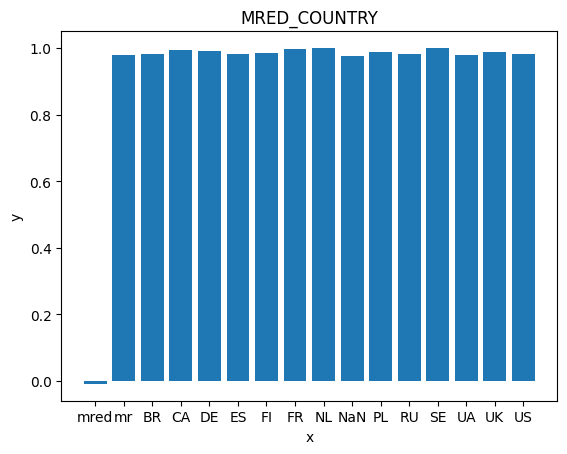

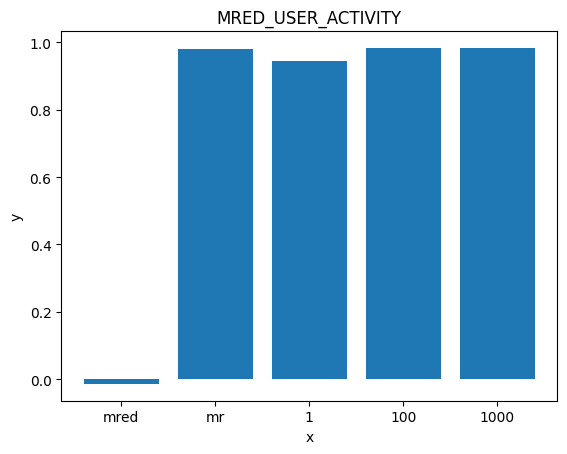

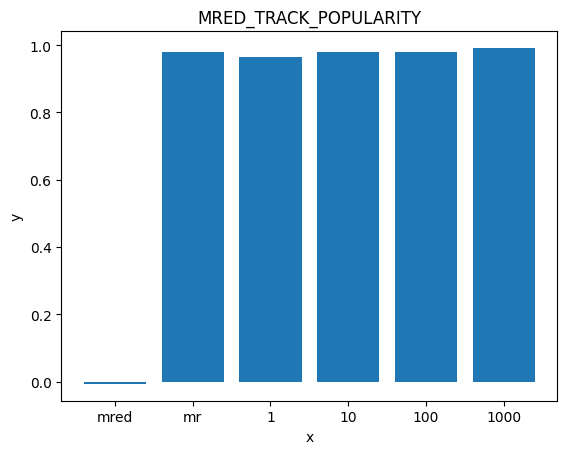

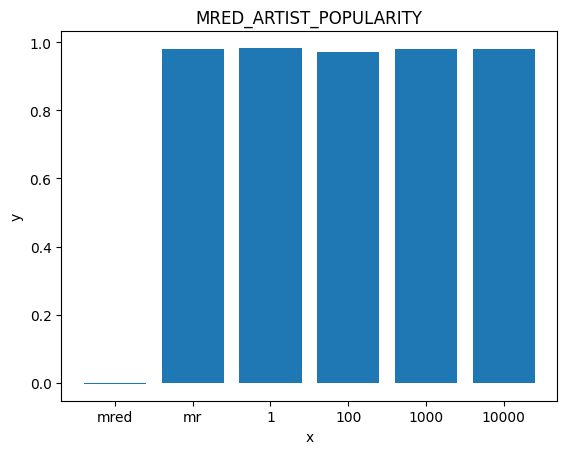

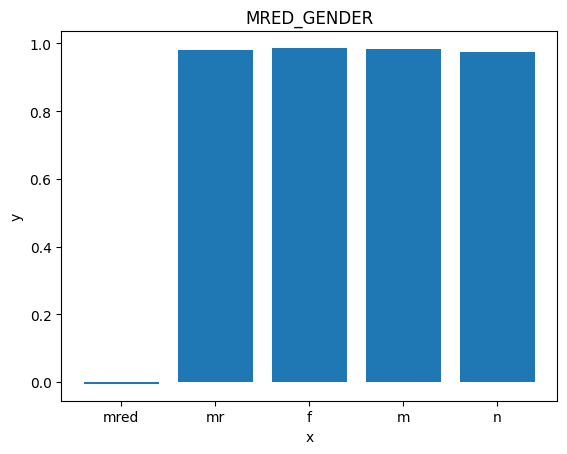

In [42]:
# initialize with everything

# load a similarity model: here we used
similarity_model = KeyedVectors.load(os.path.join(dataset.path_to_dataset, 'song2vec.wv'))

# initialize with everything
cdf = EvalRSReclist(
    dataset=dataset,
    model_name="CBOWModel",
    predictions=predicted, # Current predictions
    logger=LOGGER.LOCAL,
    metadata_store=METADATA_STORE.LOCAL,
    similarity_model=similarity_model,
)

# run reclist
cdf(verbose=True)

In [87]:
# initialize with everything

# load a similarity model: here we used
similarity_model = KeyedVectors.load(os.path.join(dataset.path_to_dataset, 'song2vec.wv'))

# initialize with everything
cdf = EvalRSReclist(
    dataset=dataset,
    model_name="CBOWModel",
    predictions=cbow_predicted_cn, # CustomerN Predictions
    logger=LOGGER.LOCAL,
    metadata_store=METADATA_STORE.LOCAL,
    similarity_model=similarity_model,
)

# run reclist

cdf(verbose=True)